# Problem statement

To predict the concrete strength using the data available in file concrete_data.xls. Apply
feature engineering and model tuning to obtain 80% to 95% of R2score.

# Data dictionary

**Given are the variable name, variable type, the measurement unit and a brief description.
The concrete compressive strength is the regression problem. The order of this listing
corresponds to the order of numerals along the rows of the database.**


**Name -- Data Type -- Measurement -- Description**
* Cement (cement) -- quantitative -- kg in a m3 mixture -- Input Variable
* Blast Furnace Slag (slag) -- quantitative -- kg in a m3 mixture -- Input Variable
* Fly Ash (ash) -- quantitative -- kg in a m3 mixture -- Input Variable
* Water (water) -- quantitative -- kg in a m3 mixture -- Input Variable
* Superplasticizer (superplastic) -- quantitative -- kg in a m3 mixture -- Input Variable
* Coarse Aggregate (coarseagg) -- quantitative -- kg in a m3 mixture -- Input Variable
* Fine Aggregate (fineagg) -- quantitative -- kg in a m3 mixture -- Input Variable
* Age(age) -- quantitative -- Day (1~365) -- Input Variable
* Concrete compressive strength(strength) -- quantitative -- MPa -- Output Variable


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format

In [235]:
#Load the file from local directory using pd.read_csv which is a special form of read_table
concrete_df = pd.read_csv("concrete.csv")
concrete_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,23.51
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,45.85
4,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28,18.29


# Exploratory data quality report

## 1. Univariate analysis

### Basic Information of the dataset including data types

In [ ]:
concrete_df.info()

### Skewness of the dataset

In [ ]:
concrete_df.skew()

### Number of unique per column

In [ ]:
concrete_df.nunique()

### Data types 

In [ ]:
concrete_df.dtypes

### Description of the independent attributes (name, range of values observed, mean and median, standard deviation and quartiles)

In [ ]:
concrete_df.describe().T

### Number of rows and columns

In [ ]:
concrete_df.shape

###  Analysis of the body of distributions / tails

In [ ]:
concrete_df.tail(10)

###  Missing values

In [ ]:
concrete_df.isna().sum()

In [24]:
concrete_df.isnull().apply(pd.value_counts)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
False,1030,1030,1030,1030,1030,1030,1030,1030,1030


### Outliers discovery using Interquartile range (IQR) and Visualization tools

In [ ]:
Q1 = concrete_df.quantile(0.25)
Q3 = concrete_df.quantile(0.75)
IQR = Q3-Q1
print(IQR)

In [ ]:
print(concrete_df < (Q1 - 1.5 * IQR))|(concrete_df > (Q3 + 1.5 * IQR))

In [ ]:
sns.boxplot(concrete_df['cement'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['slag'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['ash'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['water'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['superplastic'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['coarseagg'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['fineagg'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['age'])
plt.show()

In [ ]:
sns.boxplot(concrete_df['strength'])
plt.show()

In [ ]:
concrete_df['strength'].value_counts(normalize=True)

## 2. Bivariate analysis between the predictor variables and between the predictor variables and target column

### Using Boxplots (Visualization)

In [ ]:
for i in ['cement','slag','ash','water','superplastic','coarseagg','fineagg','age']:
    sns.boxplot(x='strength',y=i,data=concrete_df)
    plt.show()

### Group numerical variables by mean

In [ ]:
np.round(concrete_df.groupby(["strength"]).mean())

### Correlation between all variables

In [12]:
cor = concrete_df.corr()
cor

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.00,-0.28,-0.40,-0.08,0.09,-0.11,-0.22,0.08,0.50
slag,-0.28,1.00,-0.32,0.11,0.04,-0.28,-0.28,-0.04,0.13
ash,-0.40,-0.32,1.00,-0.26,0.38,-0.01,0.08,-0.15,-0.11
water,-0.08,0.11,-0.26,1.00,-0.66,-0.18,-0.45,0.28,-0.29
superplastic,0.09,0.04,0.38,-0.66,1.00,-0.27,0.22,-0.19,0.37
coarseagg,-0.11,-0.28,-0.01,-0.18,-0.27,1.00,-0.18,-0.00,-0.16
fineagg,-0.22,-0.28,0.08,-0.45,0.22,-0.18,1.00,-0.16,-0.17
age,0.08,-0.04,-0.15,0.28,-0.19,-0.00,-0.16,1.00,0.33
strength,0.50,0.13,-0.11,-0.29,0.37,-0.16,-0.17,0.33,1.00


### Using pairplots and density curves (Visualization)

In [ ]:
sns.pairplot(concrete_df,diag_kind='kde')
plt.show()

###  Findings in terms of degree of relationship between variables:

#### - The concrete is a highly non-linear function of age and other component variables 
#### - Observe the extreme values (lower and higher figures for 'strength')
#### - Cement, water, coarseagg, fineagg and age are vital components of the concrete mixture 
#### - The highest concrete strength was 82.60
#### - The lowest concrete strength was 2.33
#### - Ash doesn't seem to be that big of a deal because the experiments without ash yielded results, some of which were above 70
#### - Some concrete mixture without any slag resulted in high strength of above 70 meaning slag does not seem to be very important in this experiment
#### - There is no clear relationship between superplastic and strength because sometimes, when the superplastic is high the strength is low, when the superplastic is low, the strength is high. Sometimes in the data, they are both high.
#### - Cement and slag have a negative correlation
#### - Cement and ash have a negative correlation
#### - Cement and water have a negative correlation
#### - Cement and coarseagg have a negative correlation
#### - Cement and fineagg have a negative correlation
#### - There is a negative correlation between Strength and  ash
#### - There is also a negative correlation between water and strength
#### - There is a negative correlation between strength and coarseagg
#### - There is a negative correlation between strength and fineagg

#### - There is no strong correlation between any of the attributes

## 3. Feature Engineering techniques

### a. Identify opportunities (if any) to extract a new feature from existing features, drop a feature (if required)

In [ ]:
agg_df = concrete_df.loc[:, ['coarseagg', 'fineagg']]
agg_df['avg_aggregate'] = agg_df.mean(axis = 1)

agg_df['avg_aggregate'].value_counts()


### b. Get data model ready and do a train test split

In [49]:
concrete_df.cement.value_counts()

425.00    20
362.60    20
251.40    15
446.00    14
310.00    14
          ..
312.90     1
261.90     1
325.60     1
143.80     1
145.40     1
Name: cement, Length: 278, dtype: int64

In [21]:
concrete_df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [168]:
# Separating independent and dependent variables

x = concrete_df.drop("strength" , axis=1)
y = concrete_df["strength"]   

x = pd.get_dummies(x, drop_first=True)

In [169]:
from sklearn.model_selection import train_test_split
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

In [63]:
x_train.shape,x_test.shape

((721, 8), (309, 8))

In [54]:
x_train.dtypes

cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
dtype: object

In [39]:
y_train.dtypes

dtype('float64')

In [42]:
y_train.value_counts()

77.30    4
33.80    3
41.05    3
71.30    3
40.93    3
        ..
10.03    1
23.35    1
52.01    1
34.68    1
21.78    1
Name: strength, Length: 620, dtype: int64

In [41]:
y_test.value_counts()

33.40    3
45.08    2
31.35    2
40.06    2
45.30    2
        ..
22.35    1
64.90    1
29.65    1
20.87    1
68.50    1
Name: strength, Length: 294, dtype: int64

### c. Decide on complexity of the model, should it be simple linear model in terms of parameters or a quadratic or higher degree

In [236]:
algo= []
tr = []
te = []
recall = []
precision = []
roc = []

# Blanks list to store model name, training score, testing score, recall, precision and roc

**Linear Regression**

In [271]:
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

pred = regressor.predict(x_test)  # Predictions
score1 = regressor.score(x_test, y_test)
score1

0.8404784337617445

In [238]:
# Train R^2
print(regression_model.score(x_train, y_train))

0.6108613237504796


In [239]:
# Test R^2
print(regression_model.score(x_test, y_test))

0.6228785273568747


#### Regularized RIDGE model

In [91]:
ridge = Ridge(alpha=.3)
ridge.fit(x_train,y_train)
print ("Ridge model:", (ridge.coef_))
    

Ridge model: [ 0.11261696  0.0961643   0.0723896  -0.17865912  0.32409947  0.0119429
  0.00728736  0.11207286]


#### Regularized LASSO model

In [94]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train,y_train)
print ("Lasso model:", (lasso.coef_))


Lasso model: [ 0.11247196  0.09598976  0.07228507 -0.18037794  0.31727272  0.01157135
  0.00703007  0.1120191 ]


#### Let us compare their scores

In [121]:
print(regression_model.score(x_train, y_train))
print(regression_model.score(x_test, y_test))

0.754957826884826
0.7444710081439017


In [122]:
print(ridge.score(x_train, y_train))
print(ridge.score(x_test, y_test))

0.7549463250929687
0.7444379607063951


In [123]:
print(lasso.score(x_train, y_train))
print(lasso.score(x_test, y_test))

0.7547590604429038
0.7441326585099639


#### More or less similar results but with less complex models.  Complexity is a function of variables and coefficients
#### Note - with Lasso, the test result is slightly better than the  regression and ridge models, but the train slightly lower than the other two models.  


### Let us generate polynomial models reflecting the non-linear interaction between some dimensions

In [124]:
from sklearn.preprocessing import PolynomialFeatures

In [125]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)

#poly = PolynomialFeatures(2)

In [126]:
x_poly = poly.fit_transform(x_scaled)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.30, random_state=1)
x_train.shape

(721, 37)

### Fit a simple non regularized linear model on poly features

In [127]:
regression_model.fit(x_train, y_train)
print(regression_model.coef_[0])


5.0251228347614055e-17


In [128]:
ridge = Ridge(alpha=.3)
ridge.fit(x_train,y_train)
print ("Ridge model:", (ridge.coef_))

Ridge model: [ 0.         13.3230364   9.98806788  5.92007287 -1.6769773   4.24346992
  1.14709561  2.40295661 14.94433259  0.75048865  1.15780428 -3.8556977
 -1.72087746  0.33506201  0.61718292  2.7638557   1.74523077 -1.60892884
  0.5291864   0.35781419  2.0722416   4.15030544 -2.26730837 -2.32755965
  0.26752031  1.98410524  6.6046349   1.97079137 -1.07823346 -0.3095362
 -1.03929564  1.77010082  0.98752549  2.43497624  1.63032432 -0.31792245
  1.73711233]


In [129]:
print(ridge.score(x_train, y_train))
print(ridge.score(x_test, y_test))

0.7549463250929687
0.7444379607063951


In [130]:
lasso = Lasso(alpha=0.01)
lasso.fit(x_train,y_train)
print ("Lasso model:", (lasso.coef_))

Lasso model: [ 0.         12.95711163  9.59317708  5.56241425 -1.93810238  4.21165184
  0.92567816  2.09554658 14.88840343  0.69426378  1.08237414 -3.65259792
 -1.71422299  0.28595558  0.59790307  2.25336105  1.63038428 -1.47383575
  0.49781242  0.27234393  2.03103573  3.75939362 -2.07518639 -2.33537427
  0.22372387  1.95973654  6.14359589  1.89575026 -1.02176875 -0.27259848
 -1.27000962  1.73113555  0.8975625   2.55176152  1.59729449 -0.36995176
  1.34962187]


In [131]:
print(lasso.score(x_train, y_train))
print(lasso.score(x_test, y_test))

0.7547590604429038
0.7441326585099639


## Creating the model and tuning it

### 1. Algorithms that you think will be suitable for this project (at least 3 algorithms)

In [261]:
algo= []
tr = []
te = []
re = []
MSE = []
roc = []

# Blanks list to store model name, training score, testing score, recall, precision and roc

#### DecisionTreeRegressor

In [272]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0)  
  
# fit the regressor with X and Y data 
regressor.fit(x_train, y_train) 

pred = regressor.predict(x_test)  # Predictions
score2 = regressor.score(x_test, y_test)
score2

0.8404784337617445

In [112]:
y_pred = regressor.predict(x_test) 

In [114]:
from sklearn.metrics import mean_squared_error, r2_score

print('coefficient of determination R^2 of the prediction.: ',regressor_score)

coefficient of determination R^2 of the prediction.:  0.9948592423407845


In [115]:
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f'% r2_score(y_test, y_pred))

Mean squared error: 52.57
Test Variance score: 0.82


In [201]:
regressor_pruned = DecisionTreeRegressor(random_state = 7, max_depth=3, min_samples_leaf=5)
regressor_pruned.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=7, splitter='best')

In [202]:
## Calculating feature importance
feature_cols = x_train.columns

feat_importance = regressor_pruned.tree_.compute_feature_importances(normalize=False)


feat_imp_dict = dict(zip(feature_cols, regressor_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)[0:10] #Top 10 features

,0
cement,0.48
age,0.42
water,0.09
slag,0.00
ash,0.00
superplastic,0.00
coarseagg,0.00
fineagg,0.00


In [230]:
preds_pruned = regressor_pruned.predict(x_test)
preds_pruned_train = regressor_pruned.predict(x_train)


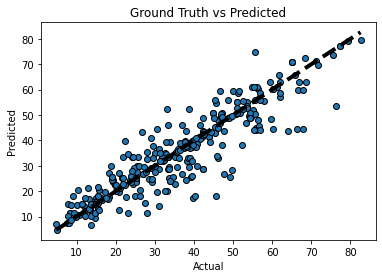

In [116]:
# So let's run the model against the test data

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

In [ ]:
#### Conclusion
#### We can see that our R2 score and MSE are both very good.
#### This means that we have found a good fitting model to predict the Pay Rate of an employee.
#### There can be a further improvement to the metric by doing some preprocessing before fitting the data.

#### RandomForestRegressor

In [273]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=7, n_estimators=50)

model.fit(x_train, y_train)


pred = model.predict(x_test)  # Predictions
score3 = model.score(x_test, y_test)
score3

0.913041041714469

In [242]:
# Bagging
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(random_state=7,n_estimators=100, max_samples= .7, bootstrap=True, oob_score=True)

model.fit(x_train, y_train)

algo.append('Bagging')
tr.append(model.score(x_train, y_train))
te.append(model.score(x_test, y_test))

#### KNeighborsRegressor

In [151]:
from sklearn.neighbors import KNeighborsRegressor
### Number of nearest neighbors
knn_clf = KNeighborsRegressor()

In [152]:
knn_clf.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [153]:
from sklearn.metrics import accuracy_score

In [154]:
param_grid = {'n_neighbors': list(range(1,9)),
             'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }

In [155]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(knn_clf,param_grid,cv=10)

In [157]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [158]:
gs.best_params_

{'algorithm': 'brute', 'n_neighbors': 3}

In [159]:
gs.cv_results_['mean_test_score']

array([0.59029391, 0.65619551, 0.67925689, 0.67103772, 0.67514392,
       0.66849236, 0.65718086, 0.65259595, 0.59029391, 0.65619551,
       0.67922073, 0.67103772, 0.67520748, 0.66784716, 0.6559687 ,
       0.65160234, 0.59029391, 0.65619551, 0.67925689, 0.67103772,
       0.67514392, 0.66849236, 0.65718086, 0.65259595, 0.59651194,
       0.66155571, 0.68062336, 0.67025779, 0.67593944, 0.6694955 ,
       0.65722806, 0.65208072])

### k-fold cross validation

In [138]:
# Evaluate using Cross Validation
from sklearn import model_selection

In [139]:
seed = 6
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
kfold = model_selection.KFold(n_splits=20)

In [140]:
model = LinearRegression()

In [141]:
x.head(2)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14


In [ ]:
results = model_selection.cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=kfold)
print("Mean Square Error: %.3f (%.3f)" % (-result`   pts.mean(), results.std())

### Use appropriate metrics and make a DataFrame to compare models w.r.t their metrics

In [266]:
results = pd.DataFrame()
results['Model'] = algo
results['Train Regression Model Score'] = tr
results ['Test Regression Model Score'] = te
results = results.set_index('Model')
results

,Train Regression Model Score,Test Regression Model Score
Model,,


###  Parameter Tuning using Grid Search 

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8],
 'n_estimators': [100]}


clf = GridSearchCV(RandomForestRegressor(), parameters, cv = 5, verbose = 2, n_jobs= 4)
clf.fit(x, y)

clf.best_params_


# Best parameters
#{'bootstrap': True,
# 'max_depth': 30,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 1,
#  'n_estimators': 100} 


In [276]:
rf = RandomForestRegressor(bootstrap= True,
 max_depth= 30,
 max_features= 'auto',
 min_samples_leaf= 1,
 n_estimators= 100)


score4 = cross_val_score(rf, x, y, cv = 5).mean()


score4

0.9068859027622829

###  Make a DataFrame to compare models after hyperparameter tuning and their metrics as above

In [249]:
concrete_df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [279]:
concrete_df = {'Technique' : ['Logistic Regression', 'Decision tree',
                       'Random forest', 'DT CV'],
       'Score' : [score1, score2, score3, score4] }

result = pd.DataFrame(concrete_df)

## Pipeline - Automate and Simplify the process

In [248]:
!pip install category_encoders

In [281]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import OrdinalEncoder



numeric_features = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'
       ]

#TRANSFORMERS



numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
                
    ])

In [282]:
#Adding into Pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(bootstrap= True,max_depth= 30,max_features= 'auto',min_samples_leaf= 1,n_estimators= 100))])

In [283]:
#Taking the raw data
concrete_df = pd.read_csv("concrete.csv")


In [284]:
#Getting x and y
x_pipe = concrete_df.drop(['strength'], axis = 1)
y_pipe = concrete_df['strength']

In [ ]:
#Data SPlit
x_trains, x_tests, y_trains, y_tests = train_test_split(x_pipe,y_pipe, stratify = y_pipe)

In [ ]:
#Fitting Pipeline 
clf.fit(x_trains, y_trains)

In [ ]:
#Getting score 
clf.score(x_tests, y_tests)

In [ ]:
# Conclusion:

- This project has clearly shown how to perform EDA for this dataset
- This data was entirely continuous. 
- Insights were provided
- Boxplots, pairplots and KDEs were used to visualize and interprete this problem
- We went beyond EDA and preprocessed our data and also trained Supervised Models with it
- We created a new feature using coarseagg and fineagg and selected the best features to improve your model further.
- We finally put all the steps in one place and built a pipeline using the Sklearn's Pipeline function